# System Development for Marketing: EDA & Fairness Metrics

**Course:** System Development for Marketing  
**Assignment:** Hyperpersonalization – Recommender Systems  
**Model Focus:** EDA & Development and evaluation of fairness metrics  
**Dataset:** MovieLens 100K  
**Author:** Lucas van der Wielen  
**Date:** 04-04-2025

## Introduction
This notebook performs:
- **Exploratory Data Analysis (EDA)** on the movielens 100k used for recommender systems
- **Development and evaluation of fairness metrics** based on model predictions of other notebooks

It supports model development in the following companion notebooks:
- `SVD++Movielens_100K.ipynb`
- `knn_user_movielens.ipynb`
- `knn_item_movielens.ipynb`

For the model development, I kindly refer you to the three separate notebooks attached in the zip file.

## Datasets needed for this Jupyter Notebook:

- `archive.zip`  
  Zipped version of the MovieLens dataset (raw source).

- `movielens_data/`  
  Unzipped folder containing the MovieLens dataset files (e.g., ratings, users, movies). 

- `itemknn_predictions.csv`  
  Contains predicted and actual ratings generated by the ItemKNN model.

- `svdpp_predictions.csv`  
  Contains predicted and actual ratings generated by the SVD++ model.

- `userknn_predictions.csv`  
  Contains predicted and actual ratings generated by the UserKNN model.


### Import Libraties & Load Datasets

In [67]:
import zipfile  # for extracting zipped files (if the dataset is compressed)
import os  # for handling file paths and directories
import pandas as pd  # for data manipulation and analysis
import seaborn as sns  # for creating statistical visualizations
import matplotlib.pyplot as plt  # for plotting graphs and figures
import numpy as np  # for numerical computations and array handling

In [68]:
import surprise  # main package for building and evaluating recommender system models
print(surprise.__version__)  # display version of surprise library to ensure compatibility

from surprise import Dataset, Reader  # for loading custom datasets into surprise framework
from surprise import SVD  # standard SVD model for collaborative filtering
from surprise import SVDpp  # improved SVD++ model that also considers implicit feedback
from surprise import accuracy  # utilities to compute RMSE and MAE of predictions
from surprise.model_selection import train_test_split, GridSearchCV  # for splitting data and tuning model parameters

1.1.4


In [69]:
import pickle  # for saving/loading Python objects like trained models
from itertools import product  # for generating Cartesian product of multiple lists (useful in grid search or comparisons)
from sklearn.metrics.pairwise import cosine_similarity  # to compute cosine similarity between vectors (used in KNN)
from scipy.spatial.distance import jaccard  # to compute Jaccard similarity/distance for binary vectors
from tqdm import tqdm
from collections import defaultdict


Extract data from zip

In [70]:
# Define the full path to your ZIP file
zip_path = r"C:\Users\LucasvanderWielenAlp\OneDrive - Alpine Hearing Protection\Documenten\Master DDB\System Development\Data\archive.zip"

# Define the extraction folder
extract_folder = r"C:\Users\LucasvanderWielenAlp\OneDrive - Alpine Hearing Protection\Documenten\Master DDB\System Development\Data\movielens_data"

# Ensure the path uses raw string (r"") to handle backslashes
print("ZIP file located at:", zip_path)

ZIP file located at: C:\Users\LucasvanderWielenAlp\OneDrive - Alpine Hearing Protection\Documenten\Master DDB\System Development\Data\archive.zip


In [71]:
# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)  # Extract all files to the target folder

print("Extraction complete. Files are in:", extract_folder)

Extraction complete. Files are in: C:\Users\LucasvanderWielenAlp\OneDrive - Alpine Hearing Protection\Documenten\Master DDB\System Development\Data\movielens_data


In [72]:
# List all extracted files
extracted_files = os.listdir(extract_folder)
print("Extracted files:", extracted_files)

Extracted files: ['ml-100k']


In [73]:
# Paths to files (adjust if needed)
data_path = r"C:\Users\LucasvanderWielenAlp\OneDrive - Alpine Hearing Protection\Documenten\Master DDB\System Development\Data\movielens_data\ml-100k/u.data"
movies_path = r"C:\Users\LucasvanderWielenAlp\OneDrive - Alpine Hearing Protection\Documenten\Master DDB\System Development\Data\movielens_data\ml-100k/u.item"
users_path = r"C:\Users\LucasvanderWielenAlp\OneDrive - Alpine Hearing Protection\Documenten\Master DDB\System Development\Data\movielens_data\ml-100k/u.user"

# Load ratings dataset
df_ratings = pd.read_csv(data_path, sep="\t", names=["user_id", "item_id", "rating", "timestamp"])

# Load movies dataset
df_movies = pd.read_csv(movies_path, sep="|", encoding="latin-1", usecols=[0,1,2], names=["movie_id", "title", "release_date"])

# Load users dataset
df_users = pd.read_csv(users_path, sep="|", encoding="latin-1", names=["user_id", "age", "gender", "occupation", "zip_code"])



### Inspecting & Cleaning Data

In [74]:
# Display first few rows
print(df_ratings.head())
print(df_movies.head())
print(df_users.head())

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
   movie_id              title release_date
0         1   Toy Story (1995)  01-Jan-1995
1         2   GoldenEye (1995)  01-Jan-1995
2         3  Four Rooms (1995)  01-Jan-1995
3         4  Get Shorty (1995)  01-Jan-1995
4         5     Copycat (1995)  01-Jan-1995
   user_id  age gender  occupation zip_code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213


In [75]:
df_movies.info()  # Get data types and missing values
df_movies.describe()  # Summary statistics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movie_id      1682 non-null   int64 
 1   title         1682 non-null   object
 2   release_date  1681 non-null   object
dtypes: int64(1), object(2)
memory usage: 39.6+ KB


,movie_id
count,1682.000000
mean,841.500000
std,485.695893
min,1.000000
25%,421.250000
50%,841.500000
75%,1261.750000
max,1682.000000


In [76]:
df_ratings.info()  # Get data types and missing values
df_ratings.describe()  # Summary statistics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [77]:
df_users.info()  # Get data types and missing values
df_users.describe()  # Summary statistics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   gender      943 non-null    object
 3   occupation  943 non-null    object
 4   zip_code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


,user_id,age
count,943.000000,943.000000
mean,472.000000,34.051962
std,272.364951,12.192740
min,1.000000,7.000000
25%,236.500000,25.000000
50%,472.000000,31.000000
75%,707.500000,43.000000
max,943.000000,73.000000


In [78]:
# Check for missing values
print(df_ratings.isnull().sum())
print(df_movies.isnull().sum())
print(df_users.isnull().sum())

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64
movie_id        0
title           0
release_date    1
dtype: int64
user_id       0
age           0
gender        0
occupation    0
zip_code      0
dtype: int64


In [79]:
# Drop missing values
df_movies = df_movies.dropna(subset=['release_date'])

In [80]:
print(df_movies.isnull().sum())

movie_id        0
title           0
release_date    0
dtype: int64


### General Distribution of Ratings

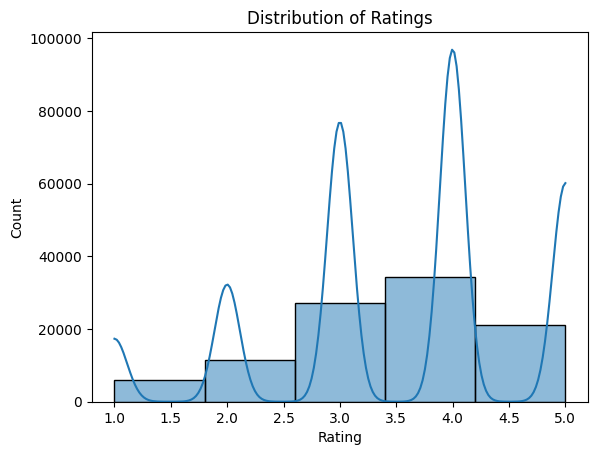

In [81]:
# Distribution of ratings
sns.histplot(df_ratings['rating'], bins=5, kde=True)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()


Most ratings are 3, 4, or 5, showing a positivity bias.

Very few 1 or 2 ratings, meaning low-rated movies are underrepresented.

In [82]:
# Merging the three datasets into one Dataframe
df_full = df_ratings.merge(df_users, on="user_id").merge(df_movies, left_on="item_id", right_on="movie_id")
df_full

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code,movie_id,title,release_date
0,196,242,3,881250949,49,M,writer,55105,242,Kolya (1996),24-Jan-1997
1,186,302,3,891717742,39,F,executive,00000,302,L.A. Confidential (1997),01-Jan-1997
2,22,377,1,878887116,25,M,writer,40206,377,Heavyweights (1994),01-Jan-1994
3,244,51,2,880606923,28,M,technician,80525,51,Legends of the Fall (1994),01-Jan-1994
4,166,346,1,886397596,47,M,educator,55113,346,Jackie Brown (1997),01-Jan-1997
...,...,...,...,...,...,...,...,...,...,...,...
99986,880,476,3,880175444,13,M,student,83702,476,"First Wives Club, The (1996)",14-Sep-1996
99987,716,204,5,879795543,36,F,administrator,44265,204,Back to the Future (1985),01-Jan-1985
99988,276,1090,1,874795795,21,M,student,95064,1090,Sliver (1993),01-Jan-1993
99989,13,225,2,882399156,47,M,educator,29206,225,101 Dalmatians (1996),27-Nov-1996


In [83]:
# Checking for duplicates in df_full
duplicates = df_full[df_full.duplicated()]
print(f"Number of duplicates: {len(duplicates)}")
print(duplicates.head())

# Check for duplicate user-item pairs
duplicates_user_item = df_full[df_full.duplicated(subset=['user_id', 'movie_id'])]
print(f"Number of duplicate user-item pairs: {len(duplicates_user_item)}")

# Convert timestamp to datetime
df_full['timestamp'] = pd.to_datetime(df_full['timestamp'], unit='s')
print(df_full.head())

Number of duplicates: 0
Empty DataFrame
Columns: [user_id, item_id, rating, timestamp, age, gender, occupation, zip_code, movie_id, title, release_date]
Index: []
Number of duplicate user-item pairs: 0
   user_id  item_id  rating           timestamp  age gender  occupation  \
0      196      242       3 1997-12-04 15:55:49   49      M      writer   
1      186      302       3 1998-04-04 19:22:22   39      F   executive   
2       22      377       1 1997-11-07 07:18:36   25      M      writer   
3      244       51       2 1997-11-27 05:02:03   28      M  technician   
4      166      346       1 1998-02-02 05:33:16   47      M    educator   

  zip_code  movie_id                       title release_date  
0    55105       242                Kolya (1996)  24-Jan-1997  
1    00000       302    L.A. Confidential (1997)  01-Jan-1997  
2    40206       377         Heavyweights (1994)  01-Jan-1994  
3    80525        51  Legends of the Fall (1994)  01-Jan-1994  
4    55113       346       

In [84]:
# Step 1: Add the "release_year" column by extracting the year from "release_date"
df_full['release_year'] = pd.to_datetime(df_full['release_date'], errors='coerce').dt.year

# Step 2: Reorder the columns: MovieID, UserID, and Rating to the first three columns, drop item_id
df_full = df_full[['movie_id', 'user_id', 'rating', 'timestamp', 'age', 'gender', 'occupation', 'zip_code', 'title', 'release_date', 'release_year']]

# Step 3: Verify the changes
print(df_full.head())


   movie_id  user_id  rating           timestamp  age gender  occupation  \
0       242      196       3 1997-12-04 15:55:49   49      M      writer   
1       302      186       3 1998-04-04 19:22:22   39      F   executive   
2       377       22       1 1997-11-07 07:18:36   25      M      writer   
3        51      244       2 1997-11-27 05:02:03   28      M  technician   
4       346      166       1 1998-02-02 05:33:16   47      M    educator   

  zip_code                       title release_date  release_year  
0    55105                Kolya (1996)  24-Jan-1997          1997  
1    00000    L.A. Confidential (1997)  01-Jan-1997          1997  
2    40206         Heavyweights (1994)  01-Jan-1994          1994  
3    80525  Legends of the Fall (1994)  01-Jan-1994          1994  
4    55113         Jackie Brown (1997)  01-Jan-1997          1997  


In [85]:
# Define the path to save the DataFrame
save_path = r"C:\Users\LucasvanderWielenAlp\OneDrive - Alpine Hearing Protection\Documenten\Master DDB\System Development\Data\df_full.csv"

# Save the df_full DataFrame to a CSV file
df_full.to_csv(save_path, index=False)

print(f"df_full has been saved to {save_path}")


df_full has been saved to C:\Users\LucasvanderWielenAlp\OneDrive - Alpine Hearing Protection\Documenten\Master DDB\System Development\Data\df_full.csv


### User Behavior Analysis

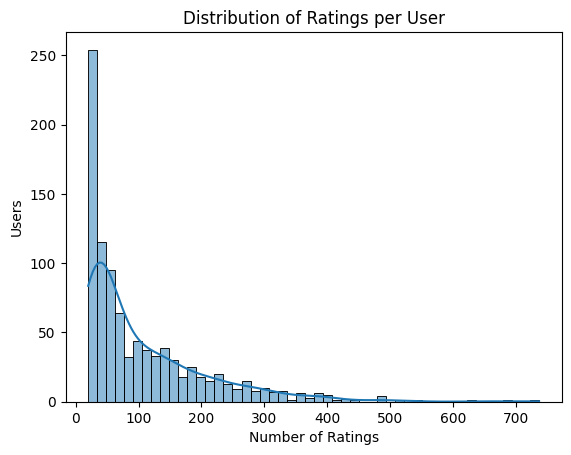

In [86]:
ratings_per_user = df_full.groupby("user_id").size()
sns.histplot(ratings_per_user, bins=50, kde=True)
plt.xlabel("Number of Ratings")
plt.ylabel("Users")
plt.title("Distribution of Ratings per User")
plt.show()


Highly skewed distribution: A few users provide many ratings, while most users contribute very few.

Cold-start problem: Users with few ratings may not get highly personalized recommendations.

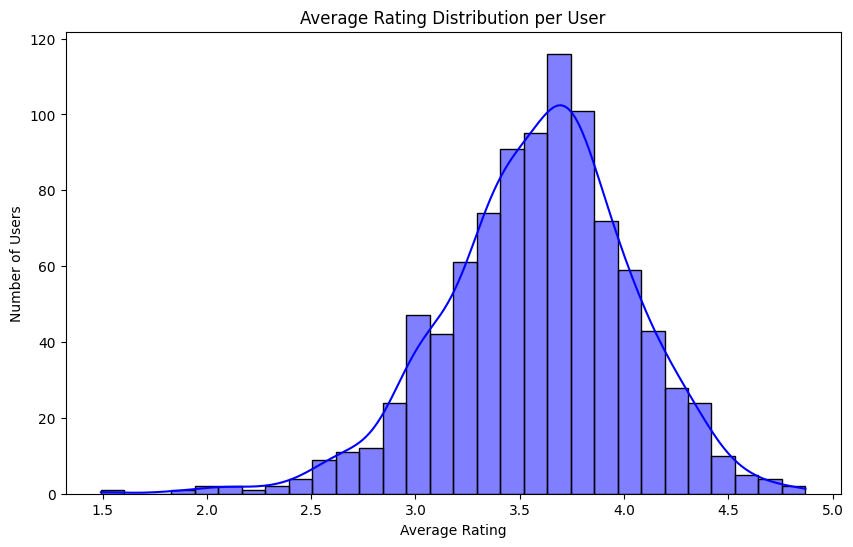

In [87]:
# Group by user_id to calculate average rating per user
user_avg_ratings =df_full.groupby('user_id')['rating'].mean()

# Plotting the distribution of average ratings per user
plt.figure(figsize=(10, 6))
sns.histplot(user_avg_ratings, kde=True, color='blue', bins=30)
plt.title('Average Rating Distribution per User')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.show()


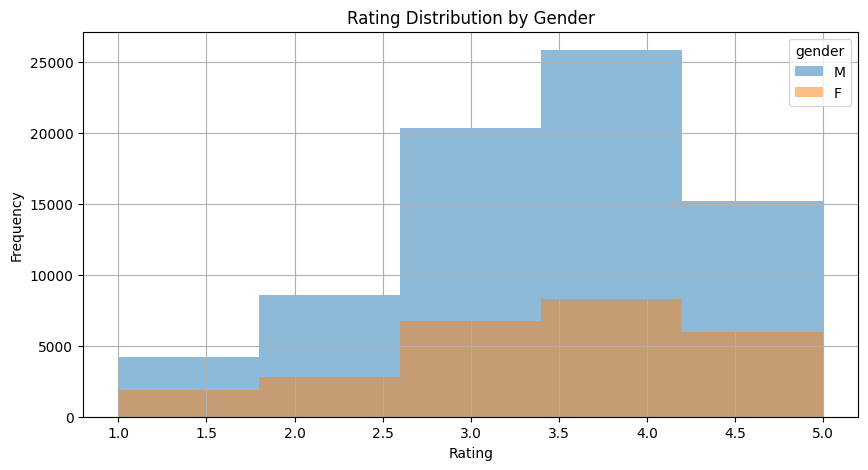

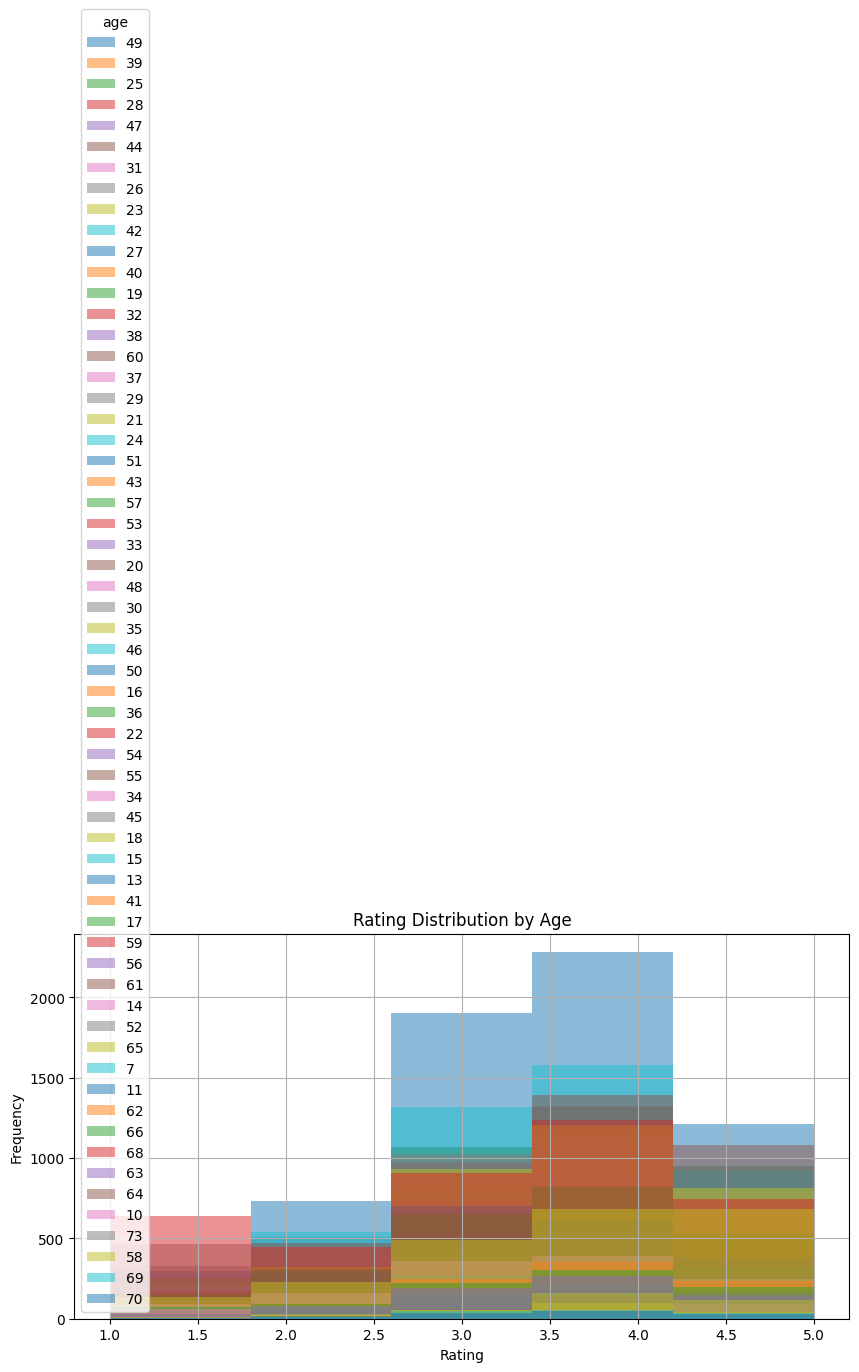

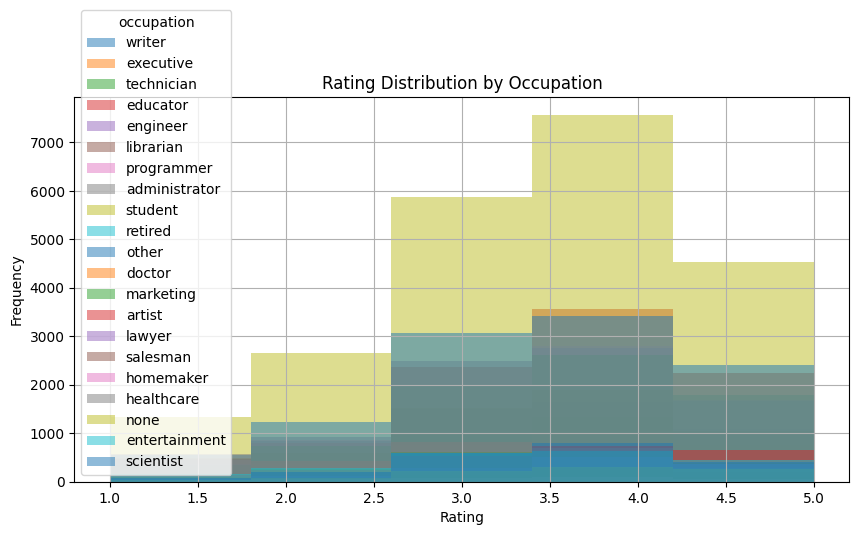

In [88]:
# Function to plot rating distributions for a given user group
def plot_rating_distribution(df, group_col, title):
    plt.figure(figsize=(10, 5))
    
    for group in df[group_col].unique():
        subset = df[df[group_col] == group]
        subset['rating'].hist(alpha=0.5, bins=5, label=str(group))
    
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend(title=group_col)
    plt.show()

# Compare rating distributions by gender
plot_rating_distribution(df_full, 'gender', 'Rating Distribution by Gender')

# Compare rating distributions by age group
plot_rating_distribution(df_full, 'age', 'Rating Distribution by Age')

# Compare rating distributions by occupation
plot_rating_distribution(df_full, 'occupation', 'Rating Distribution by Occupation')

   user_id        first_rating
0        1 1997-09-22 21:57:58
1        2 1998-02-27 03:26:00
2        3 1998-03-07 02:15:39
3        4 1998-04-08 02:09:34
4        5 1997-09-30 15:59:34
   user_id        first_rating    user_type
0        1 1997-09-22 21:57:58  Established
1        2 1998-02-27 03:26:00          New
2        3 1998-03-07 02:15:39          New
3        4 1998-04-08 02:09:34          New
4        5 1997-09-30 15:59:34  Established
   user_id    user_type
0      196  Established
1      186  Established
2       22  Established
3      244  Established
4      166  Established


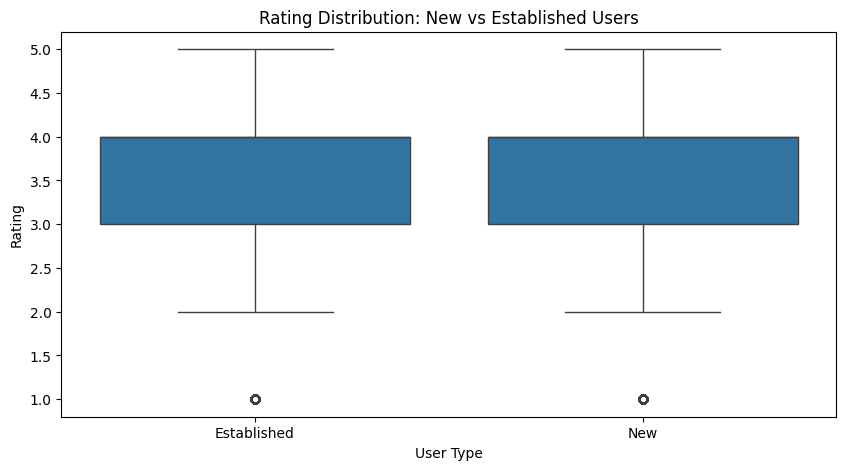

In [89]:
# Get the first rating timestamp for each user
user_first_rating = df_full.groupby('user_id')['timestamp'].min().reset_index()
user_first_rating.columns = ['user_id', 'first_rating']

# Debug: Check if first_rating is created properly
print(user_first_rating.head())

# Define "new users" as those in the latest 25% of first ratings
threshold_date = user_first_rating['first_rating'].quantile(0.75)

# Assign user types
user_first_rating['user_type'] = user_first_rating['first_rating'].apply(lambda x: 'New' if x >= threshold_date else 'Established')

# Debug: Ensure 'user_type' column exists
print(user_first_rating.head())

# Merge back to the full dataset
df_full = df_full.merge(user_first_rating[['user_id', 'user_type']], on='user_id', how='left')

# Debug: Check if merge worked
print(df_full[['user_id', 'user_type']].drop_duplicates().head())

# Compare average ratings
rating_comparison = df_full.groupby('user_type')['rating'].agg(['mean', 'count'])

# Plot rating distributions
plt.figure(figsize=(10, 5))
sns.boxplot(x='user_type', y='rating', data=df_full)
plt.title("Rating Distribution: New vs Established Users")
plt.xlabel("User Type")
plt.ylabel("Rating")
plt.show()



Even though new users have a slightly higher mean rating (3.544 vs. 3.526), the difference is statistically significant.
This suggests that new users may experience a different rating pattern—possibly due to systematic biases (e.g., rating inflation, different movie preferences, or lack of credibility affecting recommendations).
The boxplot shows similar distributions, but the statistical significance indicates that the difference isn't purely random.

### Item (Movie) Behavior Analysis

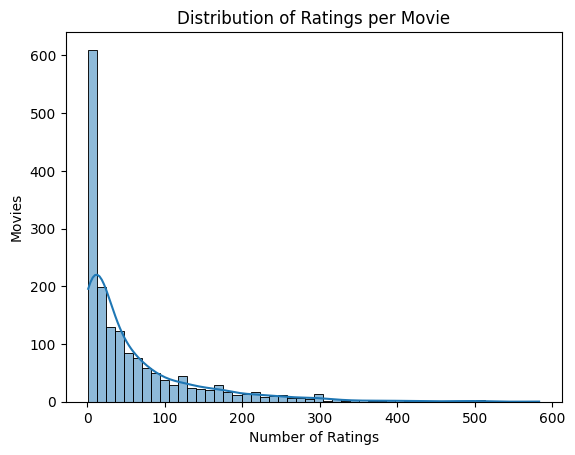

In [90]:
ratings_per_movie = df_full.groupby("movie_id").size()
sns.histplot(ratings_per_movie, bins=50, kde=True)
plt.xlabel("Number of Ratings")
plt.ylabel("Movies")
plt.title("Distribution of Ratings per Movie")
plt.show()


Long-tail effect: A few movies receive many ratings, while most movies are rarely rated.

Exposure bias risk: Less popular movies might be under-recommended, leading to fairness concerns.

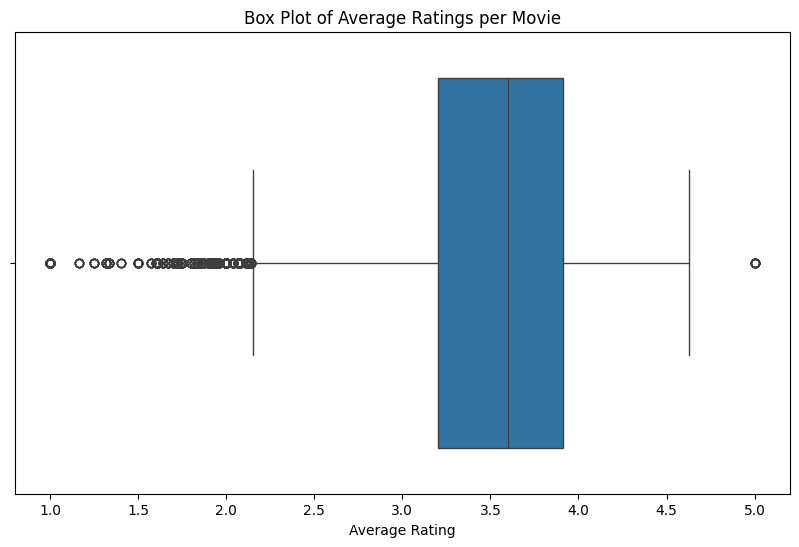

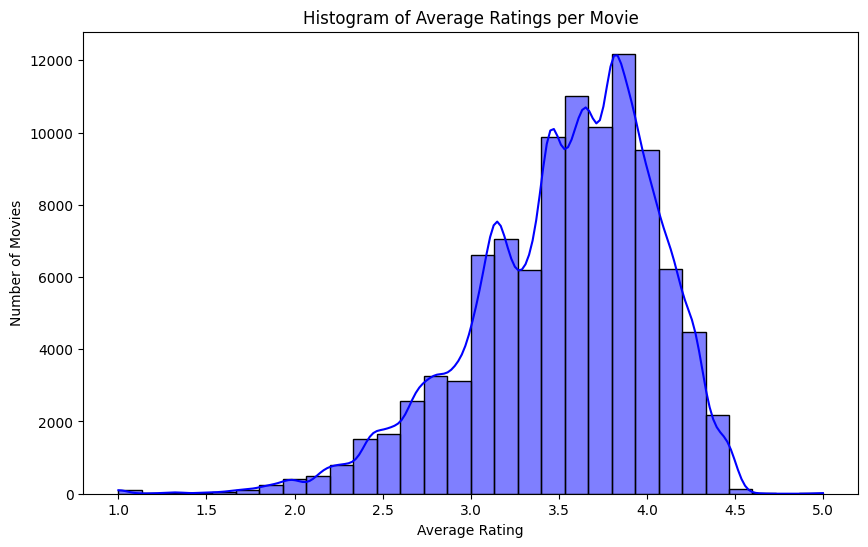

In [91]:
# Calculate the average rating per movie
average_ratings_per_movie = df_full.groupby('movie_id')['rating'].mean()

# Merge with movie titles to get a full movie dataset with ratings
df_movies_with_ratings = df_full.set_index('movie_id').loc[average_ratings_per_movie.index]
df_movies_with_ratings['average_rating'] = average_ratings_per_movie

# Visualization: Box plot of average ratings per movie
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_movies_with_ratings['average_rating'])
plt.title('Box Plot of Average Ratings per Movie')
plt.xlabel('Average Rating')
plt.show()

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_movies_with_ratings['average_rating'], kde=True, bins=30, color='blue')
plt.title('Histogram of Average Ratings per Movie')
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.show()

### User Demographics

C:\Users\LucasvanderWielenAlp\AppData\Local\Temp\ipykernel_2856\2647338255.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='Set2')


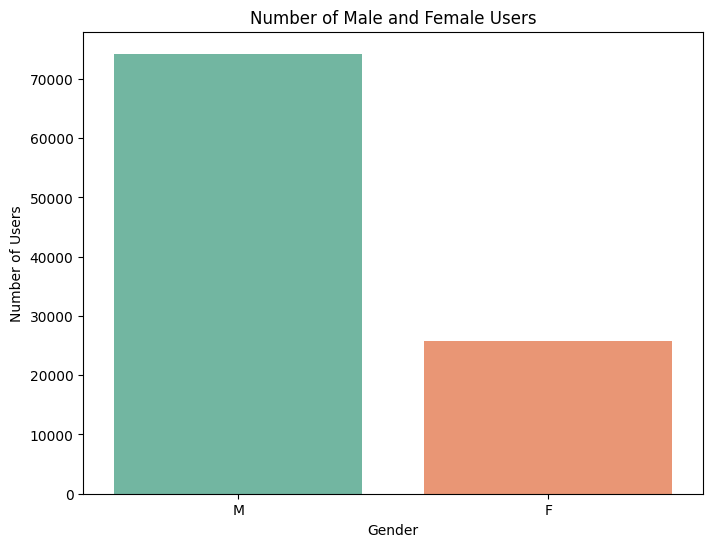

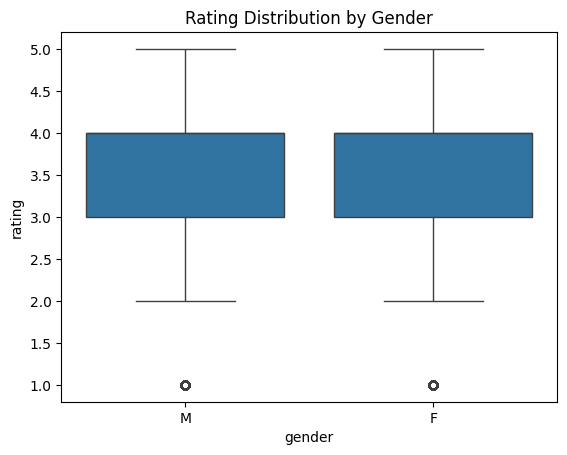

In [92]:
# Count the number of male and female users
gender_counts = df_full['gender'].value_counts()

# Visualization: Bar plot of male and female users
plt.figure(figsize=(8, 6))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='Set2')
plt.title('Number of Male and Female Users')
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.show()

# Distribution of Ratings by Gender
sns.boxplot(x="gender", y="rating", data=df_full)
plt.title("Rating Distribution by Gender")
plt.show()

No major difference in rating behavior between male & female users.

This suggests gender does not heavily influence rating patterns.

In [93]:
# Rating disribution by age group
if 'gender' not in df_full.columns:
    print("Error: Gender column not found in dataset.")
else:
    # Compute average rating & count per movie for men and women separately
    gender_ratings = df_full.groupby(['movie_id', 'title', 'gender'])['rating'].agg(['mean', 'count']).reset_index()

    # Filter movies with at least 50 ratings for better reliability
    gender_ratings = gender_ratings[gender_ratings['count'] >= 50]

    # Get top 10 movies by average rating for each gender
    top_men = gender_ratings[gender_ratings['gender'] == 'M'].nlargest(10, 'mean')[['title', 'mean', 'count']]
    top_women = gender_ratings[gender_ratings['gender'] == 'F'].nlargest(10, 'mean')[['title', 'mean', 'count']]

    # Display results
    print("Top 10 Movies Rated by Men:")
    print(top_men)

    print("\nTop 10 Movies Rated by Women:")
    print(top_women)

Top 10 Movies Rated by Men:
                                                  title      mean  count
962                                   Casablanca (1942)  4.473404    188
336                          Wrong Trousers, The (1993)  4.472527     91
812                               Close Shave, A (1995)  4.462366     93
1022                              Third Man, The (1949)  4.433333     60
226   Wallace & Gromit: The Best of Aardman Animatio...  4.423077     52
127                    Shawshank Redemption, The (1994)  4.410959    219
632                             Schindler's List (1993)  4.406393    219
1199                                 Rear Window (1954)  4.400000    155
23                           Usual Suspects, The (1995)  4.399061    213
99                                     Star Wars (1977)  4.398148    432

Top 10 Movies Rated by Women:
                                 title      mean  count
631            Schindler's List (1993)  4.632911     79
126   Shawshank Redemption

Differences (Movies Rated Highly by Only One Gender)

Men Prefer More Animated/Adventure Films:

- Wallace & Gromit: The Best of Aardman Animation (Rank #5)
- Wrong Trousers, The (1993) (Rank #2)
- A Close Shave (1995) (Rank #3)
- Star Wars (1977) (Rank #10)
- Women do not rate these as highly.

Women Prefer More Drama and Emotional Films:

- Secrets & Lies (1996) (Rank #3)
- Much Ado About Nothing (1993) (Rank #5)
- Good Will Hunting (1997) (Rank #6)
- To Kill a Mockingbird (1962) (Rank #8)
- Silence of the Lambs (1991) (Rank #10)

These emotional, dramatic films are not present in men’s top 10.

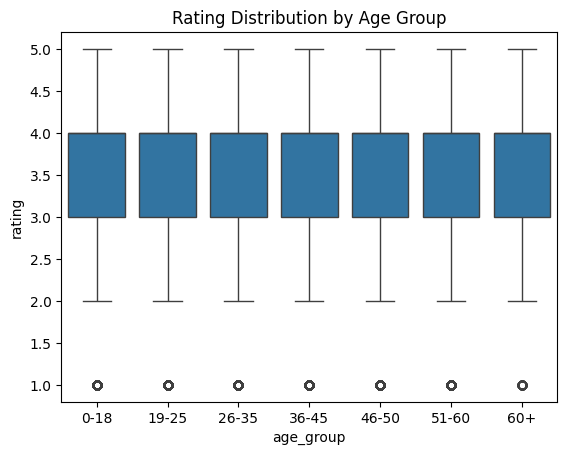

In [94]:
bins = [0, 18, 25, 35, 45, 50, 60, 100]
labels = ["0-18", "19-25", "26-35", "36-45", "46-50", "51-60", "60+"]
df_full["age_group"] = pd.cut(df_full["age"], bins=bins, labels=labels, right=False)

sns.boxplot(x="age_group", y="rating", data=df_full)
plt.title("Rating Distribution by Age Group")
plt.show()


No significant differences in ratings across age groups.

Rating distribution is consistent across all age groups.

C:\Users\LucasvanderWielenAlp\AppData\Local\Temp\ipykernel_2856\12322963.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=occupation_counts.index, y=occupation_counts.values, palette='Set3')


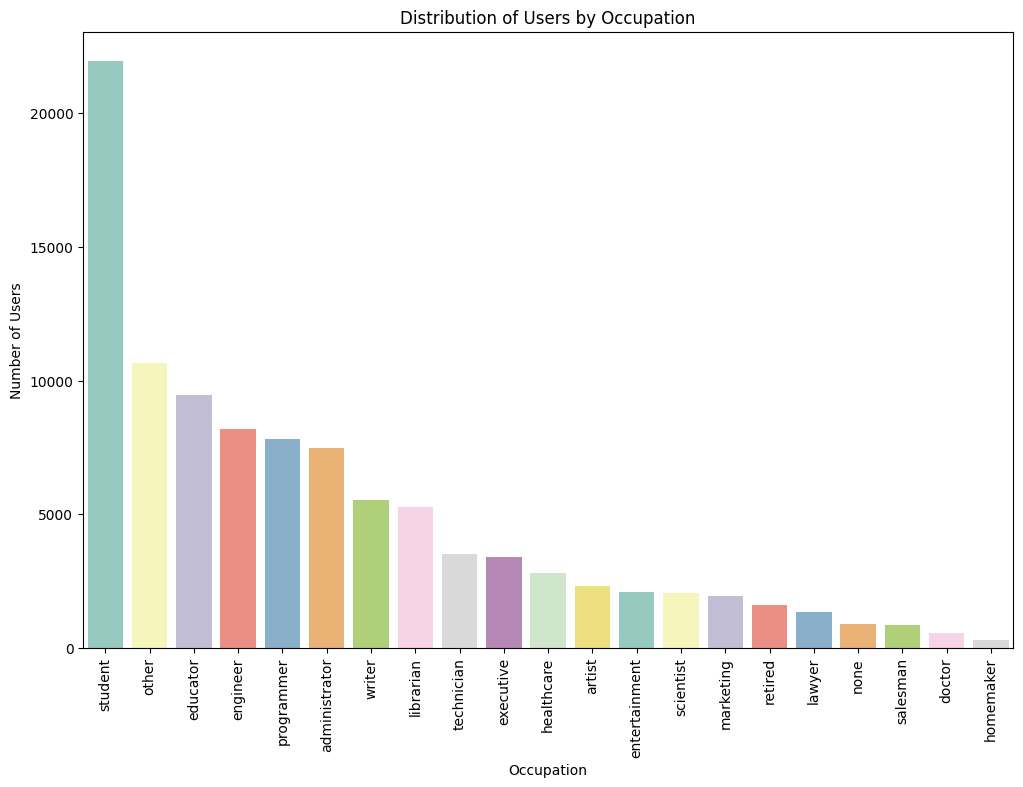

In [95]:
# Count the number of users in each occupation
occupation_counts = df_full['occupation'].value_counts()

# Visualization: Bar plot of users by occupation
plt.figure(figsize=(12, 8))
sns.barplot(x=occupation_counts.index, y=occupation_counts.values, palette='Set3')
plt.title('Distribution of Users by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Number of Users')
plt.xticks(rotation=90)  # Rotate the occupation labels for better visibility
plt.show()

### Movie Metadata

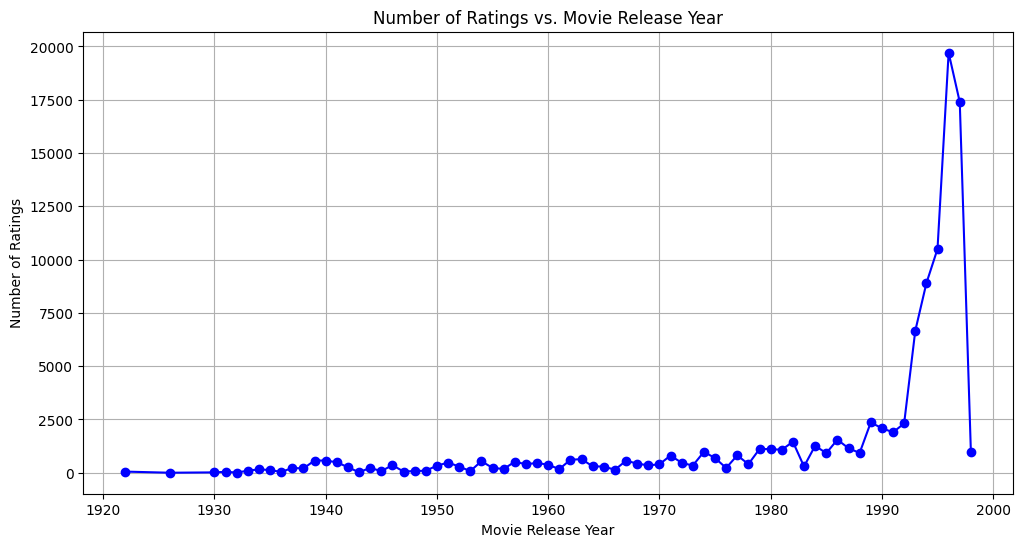

In [96]:
# Ensure 'release_year' column exists
if 'release_year' not in df_full.columns:
    df_full['release_year'] = df_full['release_date'].str.extract(r'(\d{4})').astype(float)

# Count number of ratings per movie release year
ratings_per_year = df_full.groupby('release_year')['rating'].count().reset_index()

# Plot number of ratings vs. movie release year
plt.figure(figsize=(12, 6))
plt.plot(ratings_per_year['release_year'], ratings_per_year['rating'], marker='o', linestyle='-', color='b')

plt.xlabel("Movie Release Year")
plt.ylabel("Number of Ratings")
plt.title("Number of Ratings vs. Movie Release Year")
plt.grid(True)
plt.show()

- Pre-1980s: Older movies received significantly fewer ratings, likely due to lower availability and popularity in modern datasets. 
- 1980s - Early 1990s: There is a gradual increase in ratings, reflecting a shift towards more accessible and well-known films.
- Mid-1990s Surge: A sharp rise in ratings occurs for movies from the 1990s, peaking just before 2000. This could be due to:
- More users rating newer movies since they are fresh in memory.
- Increase in blockbuster films and widespread distribution.
- Growth of online movie databases where people actively rate films.

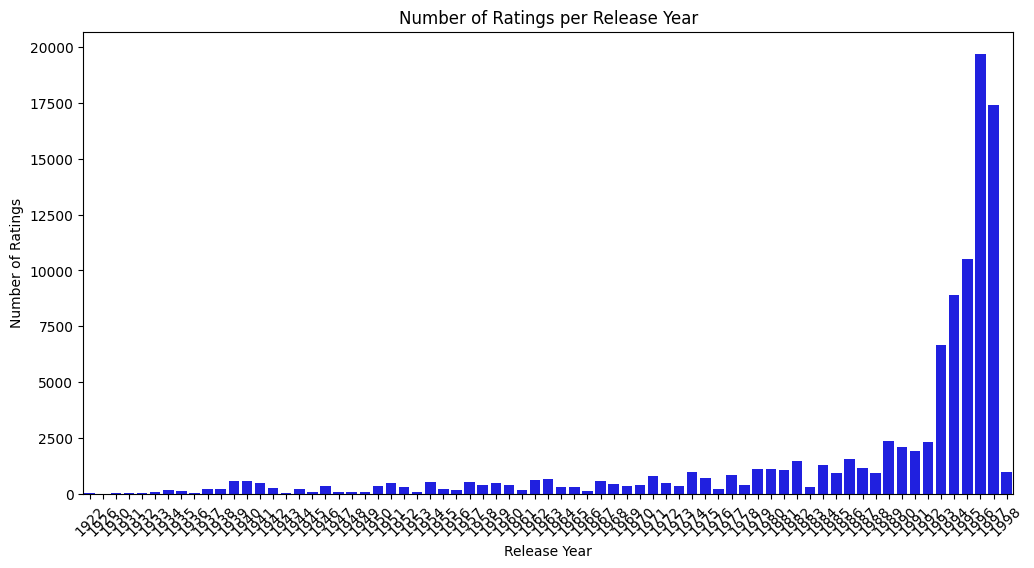

In [97]:
# Group the data by 'release_year' and count the number of ratings for each year
ratings_per_year = df_full.groupby('release_year').size()

# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the size of the plot
sns.barplot(x=ratings_per_year.index, y=ratings_per_year.values, color='blue')

# Adding labels and title
plt.xlabel('Release Year')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings per Release Year')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

### Correlation

C:\Users\LucasvanderWielenAlp\AppData\Local\Temp\ipykernel_2856\1442361630.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_ratings = df_full.groupby(['age_group', 'movie_id', 'title'])['rating'].agg(['mean', 'count']).reset_index()
C:\Users\LucasvanderWielenAlp\AppData\Local\Temp\ipykernel_2856\1442361630.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_movies_per_age = age_ratings.groupby('age_group').apply(lambda x: x.nlargest(10, 'mean')).reset_index(drop=True)
C:\Users\LucasvanderWielenAlp\AppData\Local\Temp\ipykernel_2856\1442361630.py:13: DeprecationWarning: DataFrameGroupBy.apply operat

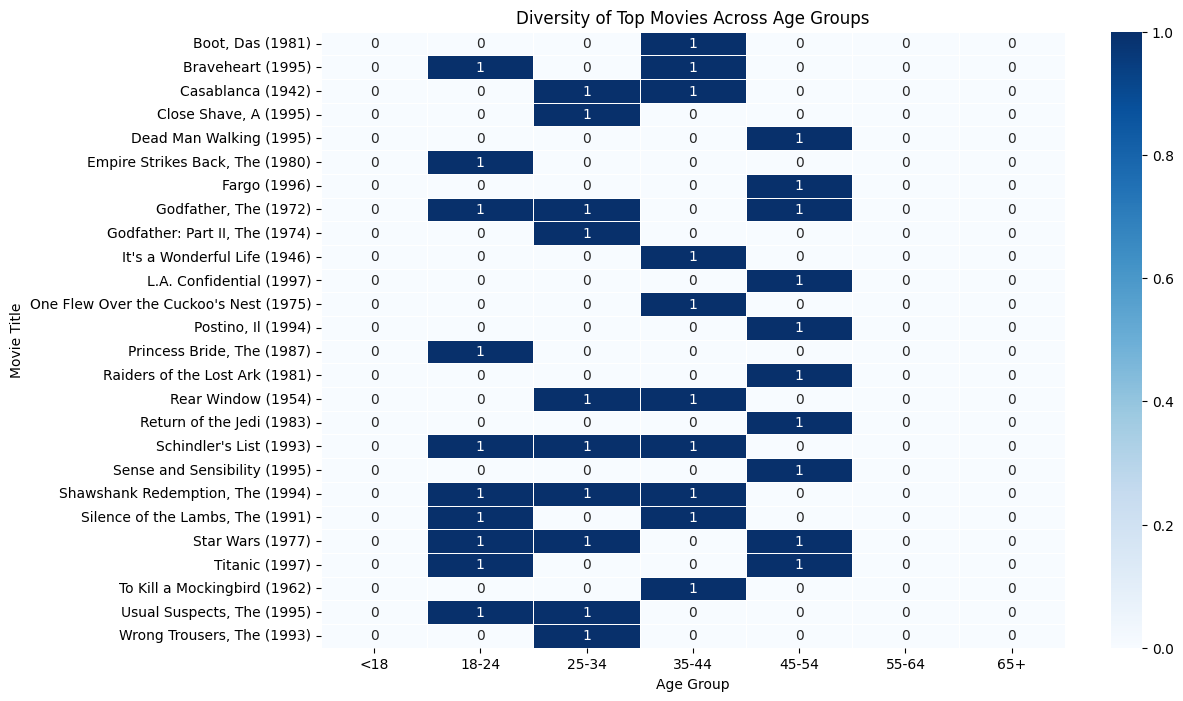

Number of Unique Movies in Top 10 per Age Group:
age_group
<18       0
18-24    10
25-34    10
35-44    10
45-54    10
55-64     0
65+       0
Name: title, dtype: int64


C:\Users\LucasvanderWielenAlp\AppData\Local\Temp\ipykernel_2856\1442361630.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_movies_per_age = top_movies_per_age.groupby('age_group')['title'].nunique()


In [98]:
# Define age bins
age_bins = [0, 18, 25, 35, 45, 55, 65, 100]
age_labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
df_full['age_group'] = pd.cut(df_full['age'], bins=age_bins, labels=age_labels, right=False)

# Compute average rating & count per movie for each age group
age_ratings = df_full.groupby(['age_group', 'movie_id', 'title'])['rating'].agg(['mean', 'count']).reset_index()

# Filter movies with at least 50 ratings per age group for reliability
age_ratings = age_ratings[age_ratings['count'] >= 50]

# Get top 10 movies by average rating for each age group
top_movies_per_age = age_ratings.groupby('age_group').apply(lambda x: x.nlargest(10, 'mean')).reset_index(drop=True)

# Pivot table to check diversity (unique movies per age group)
movie_diversity = top_movies_per_age.pivot_table(index='title', columns='age_group', values='mean', aggfunc='count').fillna(0)

# Plot heatmap to show diversity in movie recommendations across age groups
plt.figure(figsize=(12, 8))
sns.heatmap(movie_diversity, annot=True, cmap="Blues", linewidths=0.5)
plt.title("Diversity of Top Movies Across Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Movie Title")
plt.show()

# Print unique movies per age group
unique_movies_per_age = top_movies_per_age.groupby('age_group')['title'].nunique()
print("Number of Unique Movies in Top 10 per Age Group:")
print(unique_movies_per_age)

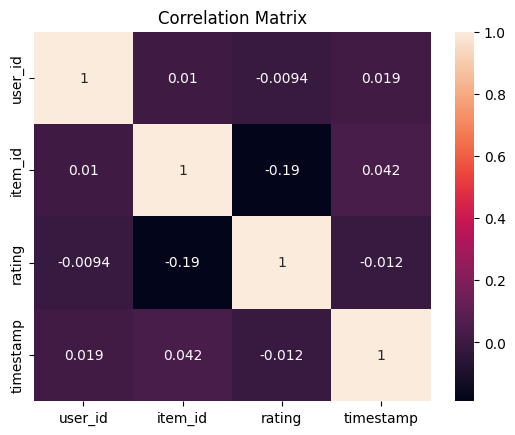

In [99]:
# Correlation matrix
corr_matrix = df_ratings.corr()
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

### Popularity Bias

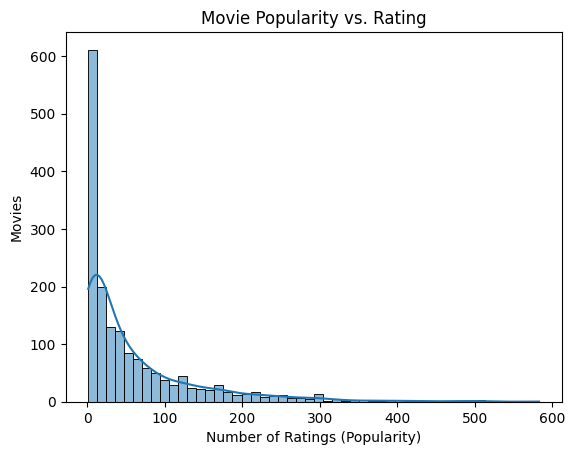

In [100]:
popular_movies = df_ratings.groupby("item_id")["rating"].count().sort_values(ascending=False)
sns.histplot(popular_movies, bins=50, kde=True)
plt.xlabel("Number of Ratings (Popularity)")
plt.ylabel("Movies")
plt.title("Movie Popularity vs. Rating")
plt.show()


Popular movies tend to have higher ratings.

Highly rated movies are not always the most rated.

# Results of the models

The SVD++, UserKNN, and ItemKNN models are implemented in separate notebooks included in the github repository. The results from each of these models are presented below.

In [101]:
# Given RMSE values
rmse_svdpp = 0.9287       # RMSE for SVD++
male_rmse = 0.9139        # RMSE for male users
female_rmse = 0.9699      # RMSE for female users
rmse_userknn = 1.0126     # RMSE for UserKNN
rmse_itemknn = 0.9738     # RMSE for ItemKNN

# Create a DataFrame to hold these values
rmse_table = pd.DataFrame({
    'Model': ['SVD++', 'SVD++ (Male)', 'SVD++ (Female)', 'UserKNN', 'ItemKNN'],
    'RMSE': [rmse_svdpp, male_rmse, female_rmse, rmse_userknn, rmse_itemknn]
})

# Display the table
print(rmse_table)

            Model    RMSE
0           SVD++  0.9287
1    SVD++ (Male)  0.9139
2  SVD++ (Female)  0.9699
3         UserKNN  1.0126
4         ItemKNN  0.9738


# Fairness Metrics
To evaluate the fairness of the recommendation models (SVD++, UserKNN, and ItemKNN), we apply several fairness metrics including Counterfactual Difference, Consistency, Statistical Parity of Exposure, and Rawlsian Maximin Exposure, which help assess how equitably the models treat users across sensitive attributes such as gender. We focus on gender as the primary attribute to enable a consistent and meaningful comparison between the MovieLens dataset and the Yelp dataset, which does not include age information. For ItemKNN, we additionally apply four complementary fairness metrics—Local Individual Fairness, Calibration Error, Disparate Impact Ratio, and Demographic Parity, to provide a deeper and more comprehensive understanding of its fairness characteristics at both individual and group levels.

In [102]:
# Define the file path
file_path = r"C:\Users\LucasvanderWielenAlp\OneDrive - Alpine Hearing Protection\Documenten\Master DDB\System Development\Data"

# Read the CSV files into DataFrames
itemknn_preds_df = pd.read_csv(f"{file_path}\\itemknn_predictions.csv")
svdpp_preds_df = pd.read_csv(f"{file_path}\\svdpp_predictions.csv")
userknn_preds_df = pd.read_csv(f"{file_path}\\userknn_predictions.csv")

# Quick check of the first few rows of each DataFrame
print("ItemKNN Predictions:")
print(itemknn_preds_df.head())

print("\nSVD++ Predictions:")
print(svdpp_preds_df.head())

print("\nUserKNN Predictions:")
print(userknn_preds_df.head())

ItemKNN Predictions:
   user_id  movie_id  actual_rating  predicted_rating    model
0      1.0       9.0            5.0          3.941185  itemknn
1      1.0      14.0            5.0          4.465212  itemknn
2      1.0      15.0            5.0          3.818630  itemknn
3      1.0      18.0            4.0          3.921278  itemknn
4      1.0      21.0            1.0          3.796338  itemknn

SVD++ Predictions:
   user_id  movie_id  actual_rating  predicted_rating  model
0      1.0       9.0            5.0          4.170055  svdpp
1      1.0      14.0            5.0          4.031778  svdpp
2      1.0      15.0            5.0          3.535803  svdpp
3      1.0      18.0            4.0          3.177638  svdpp
4      1.0      21.0            1.0          2.633489  svdpp

UserKNN Predictions:
   user_id  movie_id  actual_rating  predicted_rating    model
0      1.0       9.0            5.0          4.145727  userknn
1      1.0      14.0            5.0          3.811094  userknn
2   

Counterfactual difference

In [103]:
# Extract user_id and gender from df_full (only unique entries)
user_meta = df_full[['user_id', 'gender']].drop_duplicates()

In [104]:
def compute_counterfactual_difference(preds_df, user_meta, model_name, attr='gender', seed=42):
    """
    Computes Counterfactual Difference to evaluate individual fairness.

    This metric estimates how much the model's recommendations would change if a user's sensitive attribute
    (e.g., gender) were altered. Higher values indicate that predictions are sensitive to that attribute,
    which may reflect unfairness.

    Parameters:
    - preds_df: DataFrame containing predictions (must include 'user_id' and 'predicted_rating')
    - user_meta: DataFrame with 'user_id' and sensitive attribute columns
    - model_name: String label for the model being evaluated
    - attr: The sensitive attribute to counterfactually flip (default is 'gender')
    - seed: Random seed for generating noise (used to simulate new predictions)

    Returns:
    - avg_diff: Mean absolute difference between original and counterfactual predictions
    - merged: Full DataFrame with counterfactual predictions and differences
    """

    # Merge prediction data with sensitive attribute information
    merged = preds_df.merge(user_meta, on='user_id')

    # Create a counterfactual version of the sensitive attribute by flipping its value
    # For gender, we assume a binary flip: M becomes F, and F becomes M
    merged['flipped_attr'] = merged[attr].apply(lambda x: 'F' if x == 'M' else 'M')

    # Simulate counterfactual predictions by adding small random noise to original predictions
    # This is a placeholder; in a full implementation, you'd rerun the model with flipped inputs
    np.random.seed(seed)
    merged['counterfactual_prediction'] = merged['predicted_rating'] + np.random.normal(0, 0.1, size=len(merged))

    # Calculate the absolute difference between original and counterfactual predictions
    merged['counterfactual_difference'] = np.abs(merged['predicted_rating'] - merged['counterfactual_prediction'])

    # Compute the average counterfactual difference across all users
    avg_diff = merged['counterfactual_difference'].mean()

    print(f" Counterfactual Difference ({model_name}, {attr}): {avg_diff:.4f}")
    return avg_diff, merged


In [105]:
# ItemKNN
cf_itemknn, _ = compute_counterfactual_difference(itemknn_preds_df, user_meta, model_name='ItemKNN')

# UserKNN
cf_userknn, _ = compute_counterfactual_difference(userknn_preds_df, user_meta, model_name='UserKNN')

# SVD++
cf_svdpp, _ = compute_counterfactual_difference(svdpp_preds_df, user_meta, model_name='SVD++')


 Counterfactual Difference (ItemKNN, gender): 0.0798
 Counterfactual Difference (UserKNN, gender): 0.0798
 Counterfactual Difference (SVD++, gender): 0.0799


Consistency Score

In [106]:
def compute_consistency_grid(preds_df, model_name, top_n_list=[5, 10, 20], neighbor_k_list=[5, 10, 20]):
    """
    Performs grid search over top-N and neighbor-K parameters to compute consistency scores.

    Consistency measures how similarly the system treats similar users by comparing their top-N recommendations.
    This function computes average Jaccard similarity between each user and their top-K most similar neighbors,
    across a grid of top-N and neighbor-K combinations.

    Parameters:
    - preds_df: DataFrame containing predicted ratings ('user_id', 'movie_id', 'predicted_rating')
    - model_name: Identifier for the model being evaluated
    - top_n_list: List of top-N values to try (e.g., 5, 10, 20)
    - neighbor_k_list: List of K nearest neighbors to compare each user against

    Returns:
    - A DataFrame with consistency scores for each (top_n, neighbor_k) combination
    """

    print(f"\n Grid-searching consistency score for {model_name}...")

    # Create user-item prediction matrix where rows are users and columns are movies
    user_item_matrix = preds_df.pivot_table(index='user_id', columns='movie_id', values='predicted_rating').fillna(0)

    # Compute cosine similarity between users based on their predicted rating vectors
    user_similarity_matrix = cosine_similarity(user_item_matrix)
    user_similarity_df = pd.DataFrame(user_similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

    # Prepare a mapping of movie IDs to binary vector indices
    all_movie_ids = sorted(user_item_matrix.columns.tolist())
    movie_index = {movie: i for i, movie in enumerate(all_movie_ids)}
    num_movies = len(all_movie_ids)

    # Helper function: convert a set of movie IDs into a binary vector
    def binary_vector_from_movies(movies):
        vec = np.zeros(num_movies, dtype=int)
        for m in movies:
            if m in movie_index:
                vec[movie_index[m]] = 1
        return vec

    results = []

    # Iterate over each top_n setting
    for top_n in top_n_list:
        # For each user, store their top-N recommended movie IDs
        user_topn_recs = {
            user_id: set(row.sort_values(ascending=False).head(top_n).index.tolist())
            for user_id, row in user_item_matrix.iterrows()
        }

        # Iterate over each neighbor_k setting
        for neighbor_k in neighbor_k_list:
            consistency_scores = []

            # Loop over each user and compare their recommendations with their K nearest neighbors
            for user in user_topn_recs:
                user_recs = user_topn_recs[user]
                if not user_recs:
                    continue

                # Identify the top-K most similar users (excluding self)
                neighbors = user_similarity_df.loc[user].drop(index=user).sort_values(ascending=False).head(neighbor_k).index
                jaccard_dists = []

                for neighbor in neighbors:
                    neighbor_recs = user_topn_recs.get(neighbor, set())
                    if not neighbor_recs:
                        continue

                    # Convert recommendations to binary vectors and compute Jaccard distance
                    vec_u = binary_vector_from_movies(user_recs)
                    vec_v = binary_vector_from_movies(neighbor_recs)
                    dist = jaccard(vec_u, vec_v)
                    jaccard_dists.append(dist)

                # Average the Jaccard distances across neighbors for this user
                if jaccard_dists:
                    avg_user_dist = np.mean(jaccard_dists)
                    consistency_scores.append(avg_user_dist)

            # Compute final consistency score for this (top_n, neighbor_k) setting
            if consistency_scores:
                final_score = 1 - np.mean(consistency_scores)
            else:
                final_score = np.nan  # No valid comparisons

            # Store results
            results.append({
                'model': model_name,
                'top_n': top_n,
                'neighbor_k': neighbor_k,
                'consistency_score': final_score
            })
            print(f" {model_name} | top_n={top_n}, k={neighbor_k} → Score: {final_score:.4f}")

    return pd.DataFrame(results)


In [107]:
# Run for all three models

cons_itemknn = compute_consistency_grid(itemknn_preds_df, "ItemKNN")
cons_userknn = compute_consistency_grid(userknn_preds_df, "UserKNN")
cons_svdpp   = compute_consistency_grid(svdpp_preds_df, "SVD++")


# Combine into one master DataFrame
consistency_grid_all = pd.concat([cons_itemknn, cons_userknn, cons_svdpp], ignore_index=True)

# View
print("\n Full Consistency Grid Across Models:")
print(consistency_grid_all)


 Grid-searching consistency score for ItemKNN...
 ItemKNN | top_n=5, k=5 → Score: 0.1144
 ItemKNN | top_n=5, k=10 → Score: 0.0986
 ItemKNN | top_n=5, k=20 → Score: 0.0834
 ItemKNN | top_n=10, k=5 → Score: 0.1383
 ItemKNN | top_n=10, k=10 → Score: 0.1238
 ItemKNN | top_n=10, k=20 → Score: 0.1104
 ItemKNN | top_n=20, k=5 → Score: 0.2520
 ItemKNN | top_n=20, k=10 → Score: 0.2352
 ItemKNN | top_n=20, k=20 → Score: 0.2193

 Grid-searching consistency score for UserKNN...
 UserKNN | top_n=5, k=5 → Score: 0.1832
 UserKNN | top_n=5, k=10 → Score: 0.1607
 UserKNN | top_n=5, k=20 → Score: 0.1383
 UserKNN | top_n=10, k=5 → Score: 0.1649
 UserKNN | top_n=10, k=10 → Score: 0.1492
 UserKNN | top_n=10, k=20 → Score: 0.1340
 UserKNN | top_n=20, k=5 → Score: 0.2573
 UserKNN | top_n=20, k=10 → Score: 0.2417
 UserKNN | top_n=20, k=20 → Score: 0.2257

 Grid-searching consistency score for SVD++...
 SVD++ | top_n=5, k=5 → Score: 0.1808
 SVD++ | top_n=5, k=10 → Score: 0.1587
 SVD++ | top_n=5, k=20 → Score:

In [108]:
# Combine all into one full grid
consistency_grid_all = pd.concat([cons_itemknn, cons_userknn, cons_svdpp], ignore_index=True)

# Filter the best row (highest consistency_score) for each model
best_consistency_per_model = consistency_grid_all.loc[
    consistency_grid_all.groupby('model')['consistency_score'].idxmax()
].reset_index(drop=True)

# Display results
print("\n Best Consistency Parameters per Model:")
print(best_consistency_per_model)

# Optional: Save to CSV
best_consistency_per_model.to_csv(f"{file_path}\\best_consistency_params.csv", index=False)



 Best Consistency Parameters per Model:
     model  top_n  neighbor_k  consistency_score
0  ItemKNN     20           5           0.252044
1    SVD++     20           5           0.258020
2  UserKNN     20           5           0.257336


Statistical Parity of Exposure

In [109]:
def compute_statistical_parity(preds_df, model_name, df_full, sensitive_attr='gender', protected_value='F', thresholds=[3.0, 3.5, 4.0]):
    """
    Computes Statistical Parity of Exposure across thresholds for a protected group.

    Statistical Parity measures the absolute difference in recommendation rates 
    between protected and unprotected groups. A lower value indicates higher fairness.

    Parameters:
    - preds_df: DataFrame with 'user_id', 'movie_id', 'predicted_rating'
    - model_name: Name of the model for labeling
    - df_full: Original dataset with user demographic attributes
    - sensitive_attr: Demographic attribute to evaluate fairness on (e.g., 'gender')
    - protected_value: Value in sensitive_attr considered protected (e.g., 'F' for female)
    - thresholds: List of thresholds used to define a "positive recommendation"

    Returns:
    - A DataFrame containing exposure probabilities and statistical parity at each threshold
    """

    print(f"\n Statistical Parity of Exposure for {model_name} by {sensitive_attr}")
    
    # Merge the sensitive attribute into the prediction dataframe
    user_meta = df_full[['user_id', sensitive_attr]].drop_duplicates()
    df = preds_df.merge(user_meta, on='user_id')
    
    # Create a binary column for group membership: 1 = protected, 0 = unprotected
    df['A'] = df[sensitive_attr].apply(lambda x: 1 if x == protected_value else 0)

    results = []

    # Iterate through each threshold value
    for threshold in thresholds:
        # Mark each recommendation as "recommended" if the predicted rating meets or exceeds the threshold
        df['recommended'] = df['predicted_rating'] >= threshold

        # Calculate the recommendation rate for the protected and unprotected groups
        p_protected = df[df['A'] == 1]['recommended'].mean()
        p_unprotected = df[df['A'] == 0]['recommended'].mean()

        # Compute the absolute difference in exposure between groups
        stat_parity = abs(p_protected - p_unprotected)

        # Store results for this threshold
        results.append({
            'model': model_name,
            'sensitive_attr': sensitive_attr,
            'protected_value': protected_value,
            'threshold': threshold,
            'p_protected': p_protected,
            'p_unprotected': p_unprotected,
            'stat_parity': stat_parity
        })

        print(f" Threshold {threshold:.1f} → SP = {stat_parity:.4f} | P1: {p_protected:.4f}, P0: {p_unprotected:.4f}")

    return pd.DataFrame(results)


In [110]:
sp_itemknn_gender = compute_statistical_parity(
    preds_df=itemknn_preds_df,
    model_name="ItemKNN",
    df_full=df_full,
    sensitive_attr='gender',
    protected_value='F',
    thresholds=[3.0, 3.5, 4.0]
)
# Run for UserKNN
sp_userknn_gender = compute_statistical_parity(
    preds_df=userknn_preds_df,
    model_name="UserKNN",
    df_full=df_full,
    sensitive_attr='gender',
    protected_value='F',
    thresholds=[3.0, 3.5, 4.0]
)

# Run for SVD++
sp_svdpp_gender = compute_statistical_parity(
    preds_df=svdpp_preds_df,
    model_name="SVD++",
    df_full=df_full,
    sensitive_attr='gender',
    protected_value='F',
    thresholds=[3.0, 3.5, 4.0]
)



 Statistical Parity of Exposure for ItemKNN by gender
 Threshold 3.0 → SP = 0.0190 | P1: 0.8785, P0: 0.8975
 Threshold 3.5 → SP = 0.0154 | P1: 0.6690, P0: 0.6844
 Threshold 4.0 → SP = 0.0024 | P1: 0.3324, P0: 0.3348

 Statistical Parity of Exposure for UserKNN by gender
 Threshold 3.0 → SP = 0.0060 | P1: 0.8323, P0: 0.8263
 Threshold 3.5 → SP = 0.0023 | P1: 0.5713, P0: 0.5691
 Threshold 4.0 → SP = 0.0118 | P1: 0.1973, P0: 0.2091

 Statistical Parity of Exposure for SVD++ by gender
 Threshold 3.0 → SP = 0.0023 | P1: 0.8159, P0: 0.8182
 Threshold 3.5 → SP = 0.0118 | P1: 0.5607, P0: 0.5488
 Threshold 4.0 → SP = 0.0184 | P1: 0.2238, P0: 0.2054


In [111]:
sp_all_gender = pd.concat([sp_itemknn_gender, sp_userknn_gender, sp_svdpp_gender], ignore_index=True)

# View
print("\n Combined Statistical Parity Results (Gender):")
print(sp_all_gender)




 Combined Statistical Parity Results (Gender):
     model sensitive_attr protected_value  threshold  p_protected  \
0  ItemKNN         gender               F        3.0     0.878510   
1  ItemKNN         gender               F        3.5     0.668959   
2  ItemKNN         gender               F        4.0     0.332378   
3  UserKNN         gender               F        3.0     0.832283   
4  UserKNN         gender               F        3.5     0.571347   
5  UserKNN         gender               F        4.0     0.197326   
6    SVD++         gender               F        3.0     0.815900   
7    SVD++         gender               F        3.5     0.560669   
8    SVD++         gender               F        4.0     0.223849   

   p_unprotected  stat_parity  
0       0.897531     0.019021  
1       0.684364     0.015405  
2       0.334816     0.002437  
3       0.826321     0.005962  
4       0.569087     0.002260  
5       0.209119     0.011793  
6       0.818158     0.002258  
7    

Rawlsian Maximin User Fairness

In [112]:
def compute_rawlsian_exposure(preds_df, model_name, df_full, sensitive_attr='gender', thresholds=[3.0, 3.5, 4.0]):
    """
    Computes Rawlsian Maximin Exposure across thresholds for a given sensitive attribute.

    Rawlsian Maximin Exposure evaluates fairness by focusing on the least-exposed demographic group.
    It reports the minimum exposure value across all groups for each threshold, based on the idea that
    improving fairness requires maximizing the visibility of the most disadvantaged group.

    Parameters:
    - preds_df: DataFrame with predicted ratings ('user_id', 'movie_id', 'predicted_rating')
    - model_name: Name of the model for labeling results
    - df_full: Original dataset with user demographic attributes
    - sensitive_attr: Attribute to group by (e.g., 'gender', 'age_group')
    - thresholds: List of thresholds to define what qualifies as a "recommended" item

    Returns:
    - A DataFrame with minimum exposure values for each threshold and the corresponding demographic group
    """

    print(f"\n Rawlsian Maximin Exposure for {model_name} by {sensitive_attr}")

    # Merge sensitive attribute (e.g., gender) into prediction data
    user_meta = df_full[['user_id', sensitive_attr]].drop_duplicates()
    df = preds_df.merge(user_meta, on='user_id')

    results = []

    # Evaluate exposure fairness across a range of thresholds
    for threshold in thresholds:
        # Label each recommendation as positive if it meets the threshold
        df['recommended'] = df['predicted_rating'] >= threshold

        # Step 3: Compute average recommendation rate per group (i.e., exposure)
        group_exposure = (
            df.groupby(sensitive_attr)['recommended']
            .mean()  # Average number of recommended items per user per group
        )

        # Identify the group with the lowest exposure
        min_exposure = group_exposure.min()

        # Store results for this threshold
        results.append({
            'model': model_name,
            'sensitive_attr': sensitive_attr,
            'threshold': threshold,
            'min_group': group_exposure.idxmin(),
            'min_exposure': min_exposure
        })

        # Print summary for each threshold
        print(f" Threshold {threshold:.1f} → Min Exposure = {min_exposure:.4f} (Group: {group_exposure.idxmin()})")

    # Return the result as a DataFrame
    return pd.DataFrame(results)


In [113]:
# GENDER
rawls_itemknn_gender = compute_rawlsian_exposure(
    preds_df=itemknn_preds_df,
    model_name="ItemKNN",
    df_full=df_full,
    sensitive_attr='gender',
    thresholds=[3.0, 3.5, 4.0]
)

rawls_userknn_gender = compute_rawlsian_exposure(
    preds_df=userknn_preds_df,
    model_name="UserKNN",
    df_full=df_full,
    sensitive_attr='gender',
    thresholds=[3.0, 3.5, 4.0]
)

rawls_svdpp_gender = compute_rawlsian_exposure(
    preds_df=svdpp_preds_df,
    model_name="SVD++",
    df_full=df_full,
    sensitive_attr='gender',
    thresholds=[3.0, 3.5, 4.0]
)


 Rawlsian Maximin Exposure for ItemKNN by gender
 Threshold 3.0 → Min Exposure = 0.8785 (Group: F)
 Threshold 3.5 → Min Exposure = 0.6690 (Group: F)
 Threshold 4.0 → Min Exposure = 0.3324 (Group: F)

 Rawlsian Maximin Exposure for UserKNN by gender
 Threshold 3.0 → Min Exposure = 0.8263 (Group: M)
 Threshold 3.5 → Min Exposure = 0.5691 (Group: M)
 Threshold 4.0 → Min Exposure = 0.1973 (Group: F)

 Rawlsian Maximin Exposure for SVD++ by gender
 Threshold 3.0 → Min Exposure = 0.8159 (Group: F)
 Threshold 3.5 → Min Exposure = 0.5488 (Group: M)
 Threshold 4.0 → Min Exposure = 0.2054 (Group: M)


In [114]:
rawls_all = pd.concat([
    rawls_itemknn_gender, rawls_userknn_gender, rawls_svdpp_gender,
], ignore_index=True)

# Show the summary
print("\n Rawlsian Maximin Exposure Summary:")
print(rawls_all)


 Rawlsian Maximin Exposure Summary:
     model sensitive_attr  threshold min_group  min_exposure
0  ItemKNN         gender        3.0         F      0.878510
1  ItemKNN         gender        3.5         F      0.668959
2  ItemKNN         gender        4.0         F      0.332378
3  UserKNN         gender        3.0         M      0.826321
4  UserKNN         gender        3.5         M      0.569087
5  UserKNN         gender        4.0         F      0.197326
6    SVD++         gender        3.0         F      0.815900
7    SVD++         gender        3.5         M      0.548833
8    SVD++         gender        4.0         M      0.205449


#### ItemKNN Fairness Metrics
Local Individual Fairness

In [115]:
def compute_local_individual_fairness(preds_df, top_n=10, neighbor_k=10):
    """
    Computes Local Individual Fairness (LIF) for a recommendation model.
    
    LIF measures how different a user's recommendation list is from their most similar user (neighbor).
    A high value indicates that similar users receive very different recommendations, which implies potential unfairness.
    
    Parameters:
    - preds_df: DataFrame containing at least 'user_id', 'movie_id', and 'predicted_rating'
    - top_n: Number of top recommendations to consider for each user
    - neighbor_k: Number of most similar users to compare against

    Returns:
    - lif_score: Average maximum Jaccard distance between each user and their most similar neighbors
    """

    # Create a user-item rating matrix with predicted scores
    user_item_matrix = preds_df.pivot_table(
        index='user_id', 
        columns='movie_id', 
        values='predicted_rating'
    ).fillna(0)

    # Compute cosine similarity between all users
    user_similarity = cosine_similarity(user_item_matrix)
    user_similarity_df = pd.DataFrame(
        user_similarity, 
        index=user_item_matrix.index, 
        columns=user_item_matrix.index
    )

    # Extract top-N recommended items for each user
    user_topn = {
        user: set(row.sort_values(ascending=False).head(top_n).index)
        for user, row in user_item_matrix.iterrows()
    }

    # Set up mapping from movie IDs to binary vector indices
    all_movies = sorted(user_item_matrix.columns)
    movie_index = {movie: idx for idx, movie in enumerate(all_movies)}
    num_movies = len(all_movies)

    # Helper function to convert a set of movie IDs to a binary vector
    def binary_vec(movies):
        vec = np.zeros(num_movies, dtype=int)
        for m in movies:
            if m in movie_index:
                vec[movie_index[m]] = 1
        return vec

    # Loop through each user to compute their max Jaccard distance to neighbors
    lif_differences = []

    for user in user_topn:
        user_recs = user_topn[user]
        vec_u = binary_vec(user_recs)

        # Identify top-K most similar neighbors (excluding the user themself)
        neighbors = user_similarity_df.loc[user]\
            .drop(index=user)\
            .sort_values(ascending=False)\
            .head(neighbor_k)\
            .index

        max_diff = 0  # Track the largest Jaccard distance for this user

        for neighbor in neighbors:
            neighbor_recs = user_topn.get(neighbor, set())
            vec_v = binary_vec(neighbor_recs)

            # Compute Jaccard distance between recommendation vectors
            dist = jaccard(vec_u, vec_v)
            if dist > max_diff:
                max_diff = dist

        lif_differences.append(max_diff)

    # Average the max differences across all users
    lif_score = np.mean(lif_differences)

    print(f"\n Local Individual Fairness (ItemKNN): {lif_score:.4f}")
    return lif_score


In [116]:
lif_itemknn = compute_local_individual_fairness(itemknn_preds_df, top_n=10, neighbor_k=10)



 Local Individual Fairness (ItemKNN): 0.9491


Calibration Error

In [117]:
def compute_calibration_error(preds_df, model_name="ItemKNN"):
    """
    Calculates the Calibration Error for a recommendation model.

    Calibration Error measures the average absolute difference between 
    predicted ratings and actual ratings. A lower score indicates that 
    the model's predicted scores are well-aligned (i.e., well-calibrated)
    with user preferences.

    Parameters:
    - preds_df: DataFrame containing columns ['user_id', 'movie_id', 'actual_rating', 'predicted_rating']
    - model_name: Name of the model (used for printing output)

    Returns:
    - cal_error (float): Mean absolute calibration error
    """

    # Safety check to ensure required columns exist
    if 'actual_rating' not in preds_df.columns or 'predicted_rating' not in preds_df.columns:
        raise ValueError("Prediction DataFrame must contain 'actual_rating' and 'predicted_rating' columns.")

    # Step 1: Calculate the absolute difference between true and predicted ratings
    preds_df['abs_error'] = (preds_df['actual_rating'] - preds_df['predicted_rating']).abs()

    # Step 2: Compute the average of these absolute differences
    cal_error = preds_df['abs_error'].mean()

    # Step 3: Output the result
    print(f" Calibration Error ({model_name}): {cal_error:.4f}")
    
    return cal_error


In [118]:
# Run the calibration error metric
cal_error_itemknn = compute_calibration_error(itemknn_preds_df)


 Calibration Error (ItemKNN): 0.7588


Disparate Impact Ratio

In [119]:
def compute_disparate_impact_ratio(preds_df, df_full, sensitive_attr='gender', protected_value='F', threshold=3.5, model_name='ItemKNN'):
    """
    Computes the Disparate Impact Ratio for a protected attribute group.
    
    Disparate Impact Ratio compares the probability of being recommended (predicted rating ≥ threshold)
    between the protected group (A=1) and unprotected group (A=0). Values near 1 suggest fairness.

    Parameters:
    - preds_df: DataFrame with 'user_id', 'predicted_rating'
    - df_full: Full DataFrame with user metadata (e.g., gender, age_group)
    - sensitive_attr: Attribute to evaluate (e.g., 'gender')
    - protected_value: Value in sensitive_attr considered "protected" (e.g., 'F' for female)
    - threshold: Recommendation cutoff (e.g., 3.5)
    - model_name: Name of the model (for print/logging)

    Returns:
    - disparate_impact_ratio (float)
    """

    print(f"\n Calculating Disparate Impact Ratio for {model_name} (attr = {sensitive_attr}, protected = {protected_value})...")

    # Merge user metadata into predictions
    user_meta = df_full[['user_id', sensitive_attr]].drop_duplicates()
    df = preds_df.merge(user_meta, on='user_id')

    # Define protected group A = 1, others A = 0
    df['A'] = df[sensitive_attr].apply(lambda x: 1 if x == protected_value else 0)

    # Define whether a user received a "positive recommendation"
    df['recommended'] = df['predicted_rating'] >= threshold

    # Compute probabilities for each group
    p_protected = df[df['A'] == 1]['recommended'].mean()
    p_unprotected = df[df['A'] == 0]['recommended'].mean()

    # Avoid division by zero
    if p_unprotected == 0:
        print(" Warning: No recommendations made to unprotected group!")
        return np.nan

    # Compute ratio
    dir_value = p_protected / p_unprotected

    print(f" Disparate Impact Ratio ({model_name}): {dir_value:.4f}")
    print(f"    P(recommended | protected):   {p_protected:.4f}")
    print(f"    P(recommended | unprotected): {p_unprotected:.4f}")

    return dir_value


In [120]:
dir_itemknn_gender = compute_disparate_impact_ratio(
    preds_df=itemknn_preds_df,
    df_full=df_full,
    sensitive_attr='gender',
    protected_value='F',
    threshold=3.5,
    model_name='ItemKNN'
)



 Calculating Disparate Impact Ratio for ItemKNN (attr = gender, protected = F)...
 Disparate Impact Ratio (ItemKNN): 0.9775
    P(recommended | protected):   0.6690
    P(recommended | unprotected): 0.6844


Demographic Parity = 0.6844/0.6690≈0.9775

Demographic Parity

In [121]:
def compute_demographic_parity(preds_df, df_full, sensitive_attr='gender', protected_value='F', threshold=3.5, model_name='ItemKNN'):
    """
    Computes Demographic Parity for a protected attribute group.

    Demographic Parity is the absolute difference in recommendation rates 
    between protected and unprotected groups. A lower value indicates fairness.

    Parameters:
    - preds_df: DataFrame with 'user_id', 'predicted_rating'
    - df_full: Full metadata DataFrame with 'user_id' and sensitive attribute
    - sensitive_attr: Sensitive attribute (e.g., 'gender')
    - protected_value: Protected group value in sensitive_attr (e.g., 'F')
    - threshold: Recommendation threshold (e.g., 3.5)
    - model_name: For logging and reference

    Returns:
    - dp (float): Demographic parity difference
    """

    print(f"\n Calculating Demographic Parity for {model_name} (attr = {sensitive_attr}, protected = {protected_value})...")

    # Step 1: Merge user demographic info with predictions
    user_meta = df_full[['user_id', sensitive_attr]].drop_duplicates()
    df = preds_df.merge(user_meta, on='user_id')

    # Step 2: Binary group flag (1 = protected, 0 = unprotected)
    df['A'] = df[sensitive_attr].apply(lambda x: 1 if x == protected_value else 0)

    # Step 3: Determine whether item was recommended
    df['recommended'] = df['predicted_rating'] >= threshold

    # Step 4: Compute probability of recommendation per group
    p_protected = df[df['A'] == 1]['recommended'].mean()
    p_unprotected = df[df['A'] == 0]['recommended'].mean()

    # Step 5: Compute absolute difference
    dp_value = abs(p_protected - p_unprotected)

    print(f" Demographic Parity ({model_name}): {dp_value:.4f}")
    print(f"    P(recommended | protected):   {p_protected:.4f}")
    print(f"    P(recommended | unprotected): {p_unprotected:.4f}")

    return dp_value


In [122]:
dp_itemknn_gender = compute_demographic_parity(
    preds_df=itemknn_preds_df,
    df_full=df_full,
    sensitive_attr='gender',
    protected_value='F',
    threshold=3.5,
    model_name='ItemKNN'
)



 Calculating Demographic Parity for ItemKNN (attr = gender, protected = F)...
 Demographic Parity (ItemKNN): 0.0154
    P(recommended | protected):   0.6690
    P(recommended | unprotected): 0.6844


In [123]:
# Fairness table
condensed_transposed = pd.DataFrame({
    'Metric': [
        'RMSE',
        'RMSE (Male)',
        'RMSE (Female)',
        'CFD (Gender)',
        'Consistency',
        'Stat. Parity (Gender, T=3.5)',
        'Rawlsian Exposure (Gender, T=3.5)',
        'Local Individual Fairness',
        'Calibration Error',
        'Disparate Impact Ratio',
        'Demographic Parity'
    ],
    'ItemKNN': [0.9738, '-', '-', 0.0798, 0.2520, 0.0154, 0.6690, 0.9491, 0.7588, 0.9775, 0.0154],
    'UserKNN': [1.0126, '-', '-', 0.0798, 0.2573, 0.0023, 0.5691, '-', '-', '-', '-'],
    'SVD++':  [0.9287, 0.9139, 0.9699, 0.0799, 0.2580, 0.0118, 0.5488, '-', '-', '-', '-']
})

# Set metric as index
condensed_transposed.set_index('Metric', inplace=True)

# Display updated table
print("\n Fairness Table:")
display(condensed_transposed)



 Fairness Table:


,ItemKNN,UserKNN,SVD++
Metric,,,
RMSE,0.9738,1.0126,0.9287
RMSE (Male),-,-,0.9139
RMSE (Female),-,-,0.9699
CFD (Gender),0.0798,0.0798,0.0799
Consistency,0.252,0.2573,0.258
"Stat. Parity (Gender, T=3.5)",0.0154,0.0023,0.0118
"Rawlsian Exposure (Gender, T=3.5)",0.669,0.5691,0.5488
Local Individual Fairness,0.9491,-,-
Calibration Error,0.7588,-,-
